In [11]:
import pandas as pd
import urllib3
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [12]:
tf.__version__

'2.13.0'

In [13]:
df = pd.read_csv("C:/py_temp/ChatGPT/fra.txt", names=['src', 'tar', 'lic'], sep='\t')
del df['lic']
print('전체 샘플의 개수 :',len(df))

전체 샘플의 개수 : 227815


In [39]:
df

,src,tar
0,Go.,\t Va ! \n
1,Go.,\t Marche. \n
2,Go.,\t En route ! \n
3,Go.,\t Bouge ! \n
4,Hi.,\t Salut ! \n
...,...,...
59995,These are my students.,\t Ce sont mes élèves. \n
59996,These aren't my ideas.,\t Ce ne sont pas mes idées. \n
59997,These books are Tom's.,\t Ces livres sont à Tom. \n
59998,These books are heavy.,\t Ces livres sont lourds. \n


In [14]:
df = df.loc[:, 'src':'tar']
df = df[0:60000] # 6만개만 저장
df.sample(10)

,src,tar
17225,That isn't mine.,Ce n'est pas à moi.
31728,Are you frightened?,Êtes-vous effrayés ?
33615,I know you love me.,Je sais que tu m'aimes.
9406,Throw Tom out.,Jetez Tom dehors.
6045,My legs hurt.,J’ai mal aux jambes.
49050,I think you're lying.,Je pense que tu mens.
44674,We aren't that poor.,Nous ne sommes pas si pauvres.
47059,Everybody was silent.,Tout le monde fut silencieux.
14975,He studied hard.,Il étudiait avec application.
35659,She made him happy.,Elle l'a rendu heureux.


In [15]:
# <sos>, <eos> 나타내주기
df.tar = df.tar.apply(lambda x : '\t '+ x + ' \n')
df.sample(10)

,src,tar
32597,He can't handle it.,\t Il ne parvient pas à le gérer. \n
16721,Let me try that.,\t Laisse-moi essayer ça. \n
51801,They won't come back.,\t Ils ne vont pas revenir. \n
41325,I want to be useful.,\t Je veux être utile. \n
2804,You're big.,\t Vous êtes grand. \n
10403,Be a good girl.,\t Soyez une chic fille ! \n
23080,This dog is mine.,\t Ce chien est à moi. \n
57733,I'll make some coffee.,\t Je ferai un peu de café. \n
28166,It's one of those.,\t C'est une de celles-là. \n
25735,Everything is new.,\t Tout est nouveau. \n


In [16]:
# 글자 집합 구축 
#영어
src_vocab = set()
for line in df.src: # 1줄씩 읽음
    for char in line: # 1개의 글자씩 읽음
        src_vocab.add(char)

#불어
tar_vocab = set()
for line in df.tar:
    for char in line:
        tar_vocab.add(char)

In [17]:
src_vocab_size = len(src_vocab)+1
tar_vocab_size = len(tar_vocab)+1
print('source 문장의 char 집합 :',src_vocab_size) #영어 80가지 문자
print('target 문장의 char 집합 :',tar_vocab_size) #불어 104가지 문자

source 문장의 char 집합 : 80
target 문장의 char 집합 : 104


In [18]:
#아스키코드 기준 정렬
src_vocab = sorted(list(src_vocab))
tar_vocab = sorted(list(tar_vocab))
print(src_vocab[45:75])
print(tar_vocab[45:75])

['W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['T', 'U', 'V', 'W', 'X', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x']


In [19]:
#인덱스 정의 (공백도 생성된다!)
src_to_index = dict([(word, i+1) for i, word in enumerate(src_vocab)])
tar_to_index = dict([(word, i+1) for i, word in enumerate(tar_vocab)])
print(src_to_index)
print(tar_to_index)

{' ': 1, '!': 2, '"': 3, '$': 4, '%': 5, '&': 6, "'": 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, '?': 23, 'A': 24, 'B': 25, 'C': 26, 'D': 27, 'E': 28, 'F': 29, 'G': 30, 'H': 31, 'I': 32, 'J': 33, 'K': 34, 'L': 35, 'M': 36, 'N': 37, 'O': 38, 'P': 39, 'Q': 40, 'R': 41, 'S': 42, 'T': 43, 'U': 44, 'V': 45, 'W': 46, 'X': 47, 'Y': 48, 'Z': 49, 'a': 50, 'b': 51, 'c': 52, 'd': 53, 'e': 54, 'f': 55, 'g': 56, 'h': 57, 'i': 58, 'j': 59, 'k': 60, 'l': 61, 'm': 62, 'n': 63, 'o': 64, 'p': 65, 'q': 66, 'r': 67, 's': 68, 't': 69, 'u': 70, 'v': 71, 'w': 72, 'x': 73, 'y': 74, 'z': 75, 'é': 76, 'ï': 77, '’': 78, '€': 79}
{'\t': 1, '\n': 2, ' ': 3, '!': 4, '"': 5, '$': 6, '%': 7, '&': 8, "'": 9, '(': 10, ')': 11, ',': 12, '-': 13, '.': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, '?': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 'E': 31, 'F': 32, 'G': 33, 'H': 3

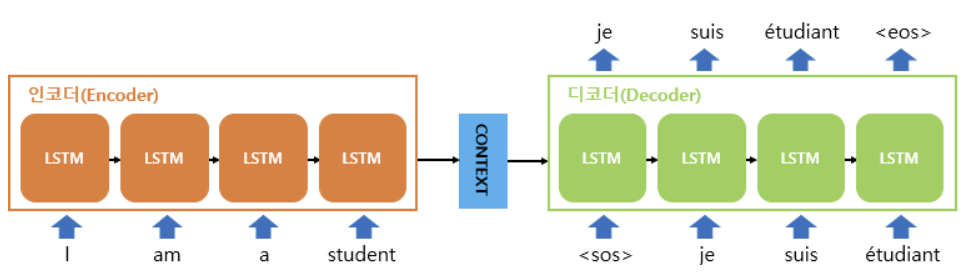

이 구조에 인코더 입력, 디코터 입출력이 다 나와있음 !!

In [20]:
#인코더 입력 
encoder_input = []

# 1개의 문장
for line in df.src:
  enc_line = []
  # 각 줄에서 1개의 char
  for char in line:
    # 각 char을 정수로 변환
    enc_line.append(src_to_index[char])
  encoder_input.append(enc_line)
print('source 문장의 정수 인코딩 :',encoder_input[:5])

source 문장의 정수 인코딩 : [[30, 64, 10], [30, 64, 10], [30, 64, 10], [30, 64, 10], [31, 58, 10]]


In [21]:
#디코더 입력 - 교사 강요 알고리즘 사용하여 예측을 하기 때문에 정답 데이터도 같이 넣어준다. 
dec_input = []
for line in df.tar:
  enc_line = []
  for char in line:
    enc_line.append(tar_to_index[char])
  dec_input.append(enc_line)
print('target 문장의 정수 인코딩 :',dec_input[:5])

target 문장의 정수 인코딩 : [[1, 3, 48, 52, 3, 4, 3, 2], [1, 3, 39, 52, 69, 54, 59, 56, 14, 3, 2], [1, 3, 31, 65, 3, 69, 66, 72, 71, 56, 3, 4, 3, 2], [1, 3, 28, 66, 72, 58, 56, 3, 4, 3, 2], [1, 3, 45, 52, 63, 72, 71, 3, 4, 3, 2]]


In [22]:
#정답 Encoding 값 (디코더 출력) - 예측값과 실제값 사이 손실함수 계산
dec_target = []
for line in df.tar:
  timestep = 0
  enc_line = []
  for char in line:
    if timestep > 0:
      enc_line.append(tar_to_index[char])
    timestep = timestep + 1
  dec_target.append(enc_line)
print('target 문장 레이블의 정수 인코딩 :',dec_target[:5])

target 문장 레이블의 정수 인코딩 : [[3, 48, 52, 3, 4, 3, 2], [3, 39, 52, 69, 54, 59, 56, 14, 3, 2], [3, 31, 65, 3, 69, 66, 72, 71, 56, 3, 4, 3, 2], [3, 28, 66, 72, 58, 56, 3, 4, 3, 2], [3, 45, 52, 63, 72, 71, 3, 4, 3, 2]]


In [23]:
max_src_len = max([len(line) for line in df.src])
max_tar_len = max([len(line) for line in df.tar])
print('source 문장의 최대 길이 :',max_src_len)
print('target 문장의 최대 길이 :',max_tar_len)

source 문장의 최대 길이 : 22
target 문장의 최대 길이 : 76


In [24]:
#Padding (같은 길이로 만들어준다.)
encoder_input = pad_sequences(encoder_input, maxlen=max_src_len, padding='post')
dec_input = pad_sequences(dec_input, maxlen=max_tar_len, padding='post')
dec_target = pad_sequences(dec_target, maxlen=max_tar_len, padding='post')

In [25]:
# 단어 범주화
encoder_input = to_categorical(encoder_input) #80개의 영단어 인코딩 
dec_input = to_categorical(dec_input) #104개의 불어 인코딩
dec_target = to_categorical(dec_target) #104개의 불어 인코딩 (정답)

In [26]:
import numpy as np
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

In [36]:
encoder_input.shape #60,000개의 문장 분석, 문자 최대 길이(22개) - 하나의 문장을 구상하는 최대 길이, 문자 종류 80가지 

(60000, 22, 80)

In [38]:
encoder_input[0] #80차원 문자 표현 - 문자를 1개씩 표현한다. (열의 개수 80개, 행의 개수 22개)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Train

#### 인코더 설계

In [27]:
## (None, 80)을 가진 문자 하나하나가 각각의 LSTM 셀에 넘어간다. 
encoder_inputs = Input(shape=(None, src_vocab_size)) #영어 문자 종류의 개수 (입력되는 문장의 길이가 모두 다르기 때문에 None으로 설정)
encoder_lstm = LSTM(units=256, return_state=True) #각각의 LSTM 셀의 출력 차원은 256, 마지막 LSTM 셀에서의 상태정보 출력

# encoder_outputs은 여기서는 불필요 - state_h, state_c를 통해 Context Vector을 넘겨준다. 
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# LSTM은 바닐라 RNN과는 달리 상태가 두 개. 은닉 상태와 셀 상태.
encoder_states = [state_h, state_c] #이게 결국 Context Vector

#### 디코더 설계

In [28]:
## (None, 104)을 가진 불어 문자 하나하나를 디코더 LSTM 셀에 넘긴다. 
dec_inputs = Input(shape=(None, tar_vocab_size))
# 모든 Cell에서 출력을 내보내기 위해 return_sequences는 True로 설정한다. (번역)
dec_lstm = LSTM(units=256, return_sequences=True, return_state=True)

# 디코더에게 인코더의 은닉 상태, 셀 상태를 전달. (예측을 하는 값을 출력하는 거라 상태정보는 따로 필요 없다. - 생각해보니 Context Vector 넘겨주는거 아니잖음)
dec_outputs, _, _= dec_lstm(dec_inputs, initial_state=encoder_states)

#각각의 LSTM 셀에서 출력은 256차원, Fully Connected - 단어 종류 104개의 노드와 출력층 256개의 노드가 연결이 1:1로 된다. (이게 Dense) 
#104개의 값들에 대한 확률 구하고 최대 확률에 해당하는 문자 1개를 출력한다. 
dec_softmax_layer = Dense(tar_vocab_size, activation='softmax')
dec_outputs = dec_softmax_layer(dec_outputs)

#### 모델 설계

In [ ]:
model = Model(x = [encoder_inputs, dec_inputs], y = dec_outputs) #X 데이터(인코더, 디코더 입력), Y 데이터(디코더 출력)(정답) 넣어주기 
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

In [29]:
model.fit(x=[encoder_input, dec_input], y=dec_target, batch_size=64, epochs=1, validation_split=0.2)

750/750 [==============================] - 343s 454ms/step - loss: 0.8459 - val_loss: 0.7730


### TEST

#### 인코더 설계

In [30]:
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states) #인코더 입력, Context Vector 출력

In [31]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 80)]        0         
                                                                 
 lstm (LSTM)                 [(None, 256),             345088    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 345088 (1.32 MB)
Trainable params: 345088 (1.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### 디코더 설계

In [32]:
#이건 그냥 정의하는거니까 실제 모델이랑 직접적 연관 없는거임
# 이전 시점의 상태들을 저장하는 텐서
dec_state_input_h = Input(shape=(256,))
dec_state_input_c = Input(shape=(256,))
dec_states_inputs = [dec_state_input_h, dec_state_input_c] #이게 다음 LSTM Cell로 넘어간다. - 이전 시점 상태를 초기 상태로 사용하기 위해서 

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용.
# 뒤의 함수 decode_sequence()에 동작을 구현 예정
dec_outputs, state_h, state_c = dec_lstm(dec_inputs, initial_state=dec_states_inputs) #상태정보랑 dec_outputs(예측값)이 나온다. 

#여기가 가장 중요한 부분인거지 ! (이게 찐모델 설계)
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태를 버리지 않음. (왜 안버림? - 이걸 통해서 예측하니까? - 문맥같은거 보려고? - 다음 시점의 초기값으로 사용되니까..)
dec_states = [state_h, state_c]
dec_outputs = dec_softmax_layer(dec_outputs) #최대 확률의 글자를 출력
dec_model = Model(inputs=[dec_inputs] + dec_states_inputs, outputs=[dec_outputs] + dec_states) #다음 상태정보 정의 

In [33]:
index_to_src = dict((i, char) for char, i in src_to_index.items())
index_to_tar = dict((i, char) for char, i in tar_to_index.items())

#### 함수 다시보기 !!!!!

In [34]:
def decode_sequence(input_seq):
  # 입력으로부터 인코더의 상태를 얻음
  states_value = encoder_model.predict(input_seq) #encoder 입력값을 통해 Context Vector을 얻는 거임 

  # <SOS>에 해당하는 원-핫 벡터 생성
  # 이 벡터를 통해 다음에 이어지는 시퀀스 생성
  target_seq = np.zeros((1, 1, tar_vocab_size)) 
  target_seq[0, 0, tar_to_index['\t']] = 1.

  stop_condition = False #True가 되는 시점은 <eos>를 만났을 때임
  dec_sentence = ""

  # <eos>를 만나기 전까지 반복하기 
  while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용 (이건 첫번째만 .. target_seq: 전에 예측한 문자랑 이전 시점 상태정보를 가지고 다음 문자를 예측하도록 한다.)
    # 즉, 이전 예측 상태 정보 + Encoder의 Context Vector 를 통해 다음 문자 예측 !!!! (이게 중요한 것)
    output_tokens, h, c = dec_model.predict([target_seq] + states_value)

    # 예측 결과를 문자로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :]) #104개의 단어 중 가장 확률이 큰 값을 뽑아낸다. - 현재 시점 예측 확률
    sampled_char = index_to_tar[sampled_token_index] #가장 확률이 큰 값에 대한 문자를 smapled_char에 저장한다. 

    # 현재 시점의 예측 문자를 예측 문장에 추가 (결국 다 모이면 단어 1개인거임 - 문자 한개씩 예측했으니까 ..)
    dec_sentence += sampled_char

    # <eos>에 도달하거나 최대 길이를 넘으면 중단. (<eos> = '\n')
    if (sampled_char == '\n' or
        len(dec_sentence) > max_tar_len):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    # 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, tar_vocab_size))
    # 단어에 대한 정보
    target_seq[0, 0, sampled_token_index] = 1. #다음 예측에 이전 시점 상태 정보를 사용하기 위해 방금의 문자 정보를 저장하는 거임

    # 상태에 대한 정보
    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장 - Test에서는 은닉, 셀 상태 버리지 X
    states_value = [h, c]

  return dec_sentence

df.src[3] = 'Go.'
'Go.'가 encoder에 들어가서 decoder로 예측값이 출력된다.

In [35]:
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스
  input_seq = encoder_input[seq_index:seq_index+1] 
  dec_sentence = decode_sequence(input_seq)
  print(35 * "-")
  print('입력 문장:', df.src[seq_index])
  print('정답 문장:', df.tar[seq_index][2:len(df.tar[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
  print('번역 문장:', dec_sentence[1:len(dec_sentence)-1]) # '\n'을 빼고 출력

1/1 [==============================] - 0s 32ms/step
-----------------------------------
입력 문장: Go.
정답 문장: Bouge ! 
번역 문장: Je me mais pait ? 
1/1 [==============================] - 0s 33ms/step
-----------------------------------
입력 문장: Hello!
정답 문장: Bonjour ! 
번역 문장: Je me mais pait ? 
1/1 [==============================] - 0s 33ms/step
-----------------------------------
입력 문장: Got it!
정답 문장: J'ai pigé ! 
번역 문장: Je me mais pait ? 
1/1 [==============================] - 0s 23ms/step
-----------------------------------
입력 문장: Go home.
정답 문장: Rentre à la maison. 
번역 문장: Je me mais pait ? 
1/1 [==============================] - 0s 48ms/step
-----------------------------------
입력 문장: Get going.
정답 문장: En avant. 
번역 문장: Je me mais pait ? 


원래 단어 단위로 번역하는게 맞으니까 문자 말고 단어로 하는게 원래 맞지만 그냥 경험 삼아서 한거임 ....
꼭 <sos>가 필요한 건 아니지만, <eos>가 있어야지 단어가 무한으로 생성 안되지 ..